In [1]:
import torch
import os
import torchvision.transforms as tfs
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchsummary import summary

from pytorch_lightning.metrics.functional import precision_recall
from pytorch_lightning.metrics.functional import accuracy

import time

from tqdm import trange
from colorama import Fore
import tqdm

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6

import time
from tqdm import tqdm

In [2]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable

You should consider upgrading via the 'c:\program files\python39\python.exe -m pip install --upgrade pip' command.


In [3]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    
    train_losses = []
    val_losses = []
    valid_accuracies = []
          
    #train part
    for epoch in range(epochs):
        model.train()
        loss_sum_tr = 0        
        
        for data, target in tqdm((train_dl),
                                 bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)):
            
            data, target = data.view(data.shape[0],-1).to(device), target.to(device)
            
            loss = loss_func(model(data), target)
            loss_sum_tr += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3)
            opt.step()
            opt.zero_grad()
            
        train_losses.append(loss_sum_tr / len(train_dl))            
        
       

        #test part
        
        model.t()
        loss_sum_val = 0
        correct = 0
        num = 0
        
        with torch.no_grad():
            for data_ts, target_ts in valid_dl:
                data_ts, target_ts = data_ts.view(data_ts.shape[0],-1).to(device), target_ts.to(device)
                probs = model(data_ts)
                loss_sum_val += loss_func(model(data_ts), target_ts).item()
                
                
                _, preds = torch.max(probs, axis =-1)
                correct += (preds == target_ts).sum().item()
                num += len(data_ts)
        
        val_losses.append(loss_sum_val / len(valid_dl))
        valid_accuracies.append(correct / num)
                
        print(f'epoch:{int(epoch+1)}\
        \t train loss:{round(loss_sum_tr / len(train_dl),4)}\
        \t valid loss:{round(loss_sum_val/len(valid_dl),4)}\
        \t valid accuracies:({correct} / {num}) {round((correct / num)*100,2)}')
        
    return train_losses, val_losses, valid_accuracies


batch_size = 1000#64
features = 784
classes = 10

device = torch.device("cpu")

In [4]:
def plot_trainig(train_losses, valid_losses, valid_accuracies):
    
    plt.xlabel('epoch')
    plt.plot(train_losses, label='train_loss')
    plt.plot(valid_losses, label='valid_loss')
    plt.legend()
    plt.show()
    
    plt.xlabel('epoch')
    plt.plot(valid_accuracies, label='valid accuracy')
    plt.legend()
    plt.show()

In [5]:
data_tfs_norm = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.1377), (0.3125))])

In [6]:
train_norm = MNIST('./', train=True, transform=data_tfs_norm, download=True,)
test_norm = MNIST('./', train=False, transform=data_tfs_norm, download=True)

train_loader_norm = DataLoader(train_norm, batch_size=batch_size,shuffle=True, drop_last=True)
test_loader_norm = DataLoader(test_norm, batch_size=batch_size,shuffle=True, drop_last=True)

data_norm = next(iter(train_norm))
print(f'mean: {data_norm[0].mean().round().item()} std:{data_norm[0].std().round().item()}')


mean: -0.0 std:1.0


In [7]:
class ModelBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.hidden1 = nn.Linear(features, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(32)
        self.output = nn.Linear(32, classes)
        self.activation = nn.ReLU()

    def forward(self, x):
        
        x = self.hidden1(x)
        x = self.activation(x)
        x = self.bn1(x)
        x = self.hidden2(x)
        x = self.activation(x)
        x = self.bn2(x)
        output = self.output(x)
        return output        
    
summary(ModelBatchNorm(), (features,), batch_size=batch_size, device='CPU')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [1000, 64]          50,240
              ReLU-2                 [1000, 64]               0
       BatchNorm1d-3                 [1000, 64]             128
            Linear-4                 [1000, 32]           2,080
              ReLU-5                 [1000, 32]               0
       BatchNorm1d-6                 [1000, 32]              64
            Linear-7                 [1000, 10]             330
Total params: 52,842
Trainable params: 52,842
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.99
Forward/backward pass size (MB): 2.27
Params size (MB): 0.20
Estimated Total Size (MB): 5.47
----------------------------------------------------------------


  2%|█▍                                                                                 | 1/60 [00:00<00:11,  5.29it/s]

epoch:1        	 train loss:30.185        	 valid loss:68.0257        	 valid accuracies:(7839 / 10000) 78.39


  2%|█▍                                                                                 | 1/60 [00:00<00:11,  5.06it/s]

epoch:2        	 train loss:27.7325        	 valid loss:17.7444        	 valid accuracies:(9099 / 10000) 90.99


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:3        	 train loss:15.2759        	 valid loss:13.4284        	 valid accuracies:(9309 / 10000) 93.09


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.49it/s]

epoch:4        	 train loss:16.0455        	 valid loss:18.1796        	 valid accuracies:(9047 / 10000) 90.47


  2%|█▍                                                                                 | 1/60 [00:00<00:11,  5.24it/s]

epoch:5        	 train loss:18.08        	 valid loss:13.8258        	 valid accuracies:(9367 / 10000) 93.67


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.49it/s]

epoch:6        	 train loss:14.9854        	 valid loss:16.3767        	 valid accuracies:(9292 / 10000) 92.92


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.49it/s]

epoch:7        	 train loss:8.2697        	 valid loss:3.4716        	 valid accuracies:(9238 / 10000) 92.38


  2%|█▍                                                                                 | 1/60 [00:00<00:11,  5.13it/s]

epoch:8        	 train loss:2.9191        	 valid loss:1.9904        	 valid accuracies:(9580 / 10000) 95.8


  2%|█▍                                                                                 | 1/60 [00:00<00:11,  5.33it/s]

epoch:9        	 train loss:1.0509        	 valid loss:2.8302        	 valid accuracies:(9543 / 10000) 95.43


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.40it/s]


epoch:10        	 train loss:1.638        	 valid loss:1.2798        	 valid accuracies:(9602 / 10000) 96.02


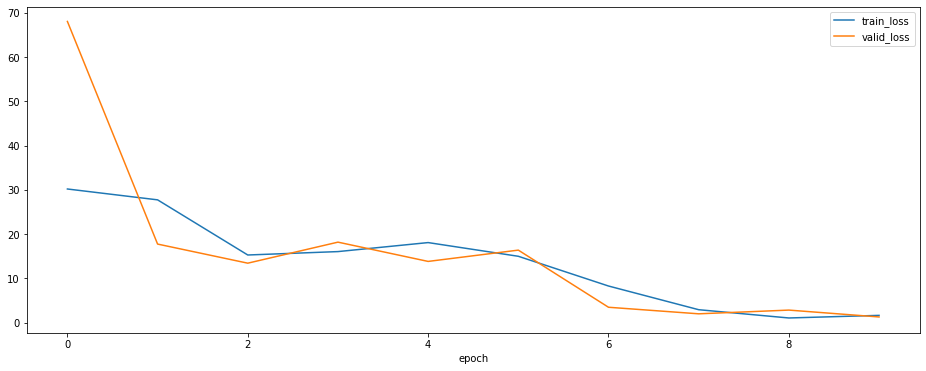

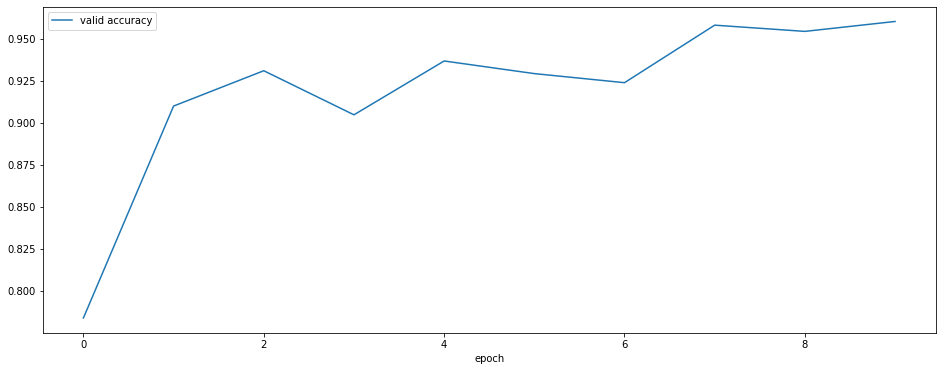

In [8]:
# Run model
model = ModelBatchNorm().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5, momentum = 0.9)
info = fit(10, model, criterion, optimizer, train_loader_norm, test_loader_norm)
plot_trainig(*info)

In [11]:
data_norm[0]

tensor([[[-4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01,
          -4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01,
          -4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01,
          -4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01,
          -4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01,
          -4.4064e-01, -4.4064e-01, -4.4064e-01],
         [-4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01,
          -4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01,
          -4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01,
          -4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01,
          -4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01,
          -4.4064e-01, -4.4064e-01, -4.4064e-01],
         [-4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01,
          -4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01, -4.4064e-01,


In [ ]:
test_image_eighty, test_target_eighty = [79]